In [57]:
# Imports
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pyeeg.spectrum import bin_power
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import tsfresh
import pandas as pd


In [2]:
# In summary, the resulting features are an array containing raw EEG data split into 5-second intervals. 
# (dimensionality of n subjects*n trials*slice_amt x n_electrodes x 128*5), which I'll call batch size.
# and the labels are an array containing valence and arousal for each 5-second interval.
# (dimensionality of n subjects*n trials*slice_amt x 2)
eeg_splitted_features = np.load('eeg_splitted_features.npy')
eeg_splitted_labels = np.load('eeg_splitted_labels.npy')

In [3]:
# Labels are originally scaled between 1 and 5. We transform them between 0 and 1.
scaled_labels = MinMaxScaler().fit_transform(eeg_splitted_labels)
valence_labels = scaled_labels[:, 0]
arousal_labels = scaled_labels[:, 1]

In [4]:
# Things associated with the GAMEEMO dataset
electrodes = 'AF3 AF4 F3 F4 F7 F8 FC5 FC6 O1 O2 P7 P8 T7 T8'.split(' ')
sample_rate = 128

In [8]:

# Extract power bands; we first flatten the first two dimensions to obtain a 2D array of voltage timeseries, we calculate band power for each electrode separately, then get the electrode dimension back. This gives us a dimensionality of (batch size x n electrodes x n bands)
reshaped_features = np.reshape(eeg_splitted_features, [eeg_splitted_features.shape[0]*eeg_splitted_features.shape[1], eeg_splitted_features.shape[2]])
extracted_powers = np.asarray([bin_power(X=feature, Band=[0.5, 3, 7, 10, 30], Fs=sample_rate) for feature in reshaped_features])[:, 0, :]
extracted_powers = np.reshape(extracted_powers, [eeg_splitted_features.shape[0], eeg_splitted_features.shape[1], extracted_powers.shape[1]])
print(extracted_powers.shape)
# Then we flatten the last two dimensions, leaving some number of bands per electrode as the final feature for each data point.
final_features = np.reshape(extracted_powers, [extracted_powers.shape[0], extracted_powers.shape[1]*extracted_powers.shape[2]])

(6549, 14, 4)


In [72]:
# We do k-fold cross validation, meaning that we hold out 10% of the data, train on the other 90%, and evaluate the model performance on the original 10%.
# We repeat this process k times. 
# As we can see, there is some overfitting as the train R^2 is much higher than the test R^2.
kf = KFold(n_splits=10, shuffle=True)
i = 0

all_predictions_arousal = np.zeros((final_features.shape[0], ))
for train_index, test_index in kf.split(final_features):
    x_train = final_features[train_index]
    y_train = arousal_labels[train_index]
    x_test = final_features[test_index]
    y_test = arousal_labels[test_index]

    xgb =  XGBRegressor()
    xgb.fit(x_train, y_train)
    

    print('Fold number ' + str(i))
    y_pred = xgb.predict(x_train)
    print('Train R^2: ' + str(r2_score(y_train, y_pred)))
    y_pred = xgb.predict(x_test)
    print('Test R^2: ' + str(r2_score(y_test, y_pred)))

    all_predictions_arousal[test_index] = y_pred
    i += 1

Fold number 0
Train R^2: 0.9758953899805367
Test R^2: 0.6066313263749536
Fold number 1
Train R^2: 0.9780807473731263
Test R^2: 0.5111546958559344
Fold number 2
Train R^2: 0.9743582618542095
Test R^2: 0.562655634393059
Fold number 3
Train R^2: 0.9758555171859136
Test R^2: 0.6107535461958435
Fold number 4
Train R^2: 0.9750194228041597
Test R^2: 0.5931917502257857
Fold number 5
Train R^2: 0.9743952824914389
Test R^2: 0.6119288343240255
Fold number 6
Train R^2: 0.9780355139499333
Test R^2: 0.5717875826382479
Fold number 7
Train R^2: 0.9734880894306039
Test R^2: 0.6097777209987247
Fold number 8
Train R^2: 0.9783340558311063
Test R^2: 0.5766014573275859
Fold number 9
Train R^2: 0.9775615421552044
Test R^2: 0.5820943651918831


In [36]:
# We do k-fold cross validation, meaning that we hold out 10% of the data, train on the other 90%, and evaluate the model performance on the original 10%.
# We repeat this process k times. 
# As we can see, there is some overfitting as the train R^2 is much higher than the test R^2.
kf = KFold(n_splits=10, shuffle=True)
i = 0

all_predictions_valence = np.zeros((final_features.shape[0], ))
for train_index, test_index in kf.split(final_features):
    x_train = final_features[train_index]
    y_train = valence_labels[train_index]
    x_test = final_features[test_index]
    y_test = valence_labels[test_index]

    xgb =  XGBRegressor()
    xgb.fit(x_train, y_train)
    

    print('Fold number ' + str(i))
    y_pred = xgb.predict(x_train)
    print('Train R^2: ' + str(r2_score(y_train, y_pred)))
    y_pred = xgb.predict(x_test)
    print('Test R^2: ' + str(r2_score(y_test, y_pred)))
    all_predictions_valence[test_index] = y_pred
    i += 1

Fold number 0
Train R^2: 0.9643207796359671
Test R^2: 0.4495396797841674
Fold number 1
Train R^2: 0.9667752019758161
Test R^2: 0.4063864694177991
Fold number 2
Train R^2: 0.9654132644589105
Test R^2: 0.4609067977703113
Fold number 3
Train R^2: 0.96613813788202
Test R^2: 0.41369733225840666
Fold number 4
Train R^2: 0.9660684802016822
Test R^2: 0.4591203469313172
Fold number 5
Train R^2: 0.9714235481339445
Test R^2: 0.4101984385086689
Fold number 6
Train R^2: 0.9632850820737674
Test R^2: 0.4567730115415566
Fold number 7
Train R^2: 0.9648224422296932
Test R^2: 0.43443871071993534
Fold number 8
Train R^2: 0.9690046617438187
Test R^2: 0.45621450084504933
Fold number 9
Train R^2: 0.9657140973467003
Test R^2: 0.40014286196741955


Text(0, 0.5, 'Arousal')

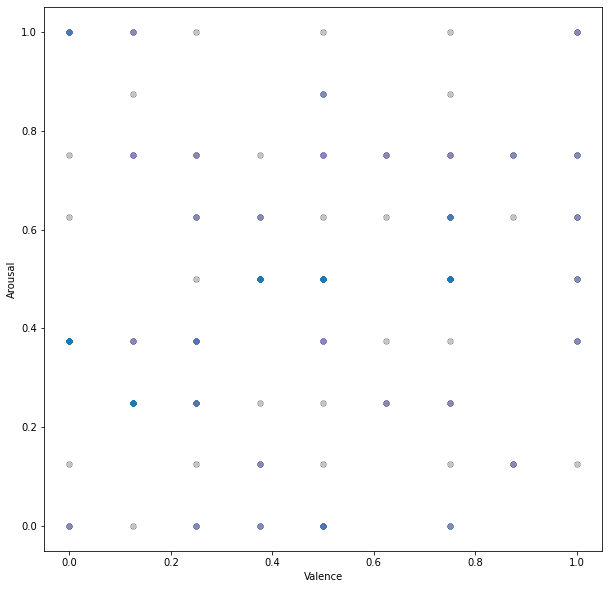

In [53]:
# A plot of the label space, the valence and arousal.
# The darker the blue, the more total labels are stacked on top of that point.

plt.figure(figsize=(10, 10))
plt.scatter(scaled_labels[:, 0], scaled_labels[:, 1], alpha=0.005)
plt.xlabel('Valence')
plt.ylabel('Arousal')

Text(0, 0.5, 'Predicted arousal')

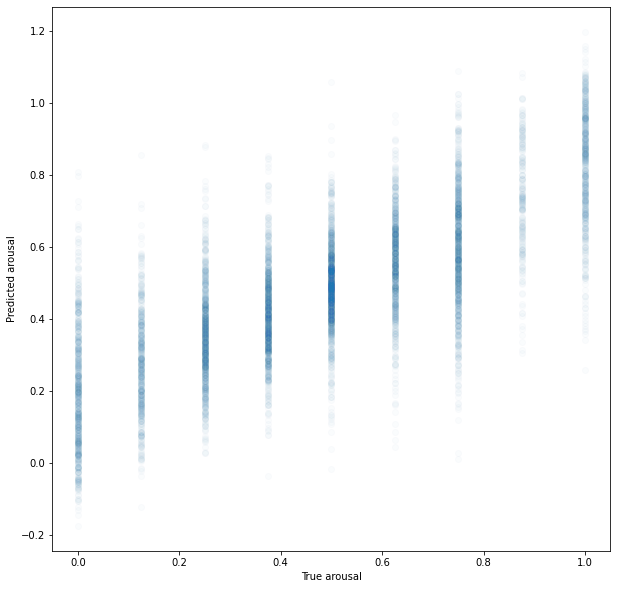

In [78]:
plt.figure(figsize=(10, 10))

plt.scatter(arousal_labels, reg.predict(np.expand_dims(all_predictions_arousal,axis=-1)), alpha=0.02)
plt.xlabel('True arousal')
plt.ylabel('Predicted arousal')

Text(0, 0.5, 'Predicted valence')

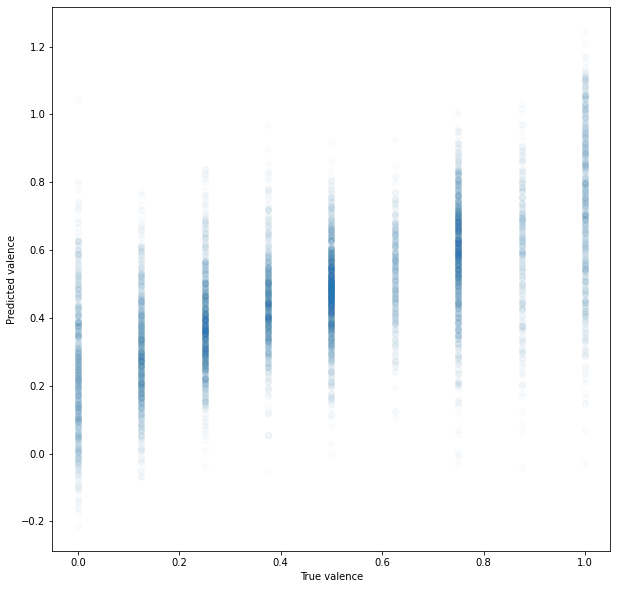

In [44]:
plt.figure(figsize=(10, 10))
plt.scatter(valence_labels, all_predictions_valence, alpha=0.02)
plt.xlabel('True valence')
plt.ylabel('Predicted valence')